In [26]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm, colors, gridspec

from colormath.color_objects import sRGBColor, LCHabColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000 as cdiff


In [2]:
R,G,B,_ = cm.viridis(np.linspace(0,1,255)).T

In [3]:
cm.viridis(0)[:3]

(0.267004, 0.004874, 0.329415)

In [4]:
def cmap_to_cobj(colormap, n=256, colorspace=sRGBColor):
    colors = [sRGBColor(*colormap(val)[:3])
             for val in np.linspace(0,1,n)]
    if colorspace is not sRGBColor:
        colors = [convert_color(color, colorspace) for color in colors]
    return colors

In [9]:
def get_cmap_cdiffs(colormap):
    colors = cmap_to_cobj(colormap, colorspace=LabColor)
    cdiffs = [cdiff(colors[i+1], colors[i]) for i in range(255)]
    return cdiffs

In [10]:
def plot_cm_cdiffs(colormap):
    diffs = get_cmap_cdiffs(colormap)
    ax1 = plt.subplot(2,1,1)
    ax1.plot(diffs)
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    ax2.imshow(np.stack([colormap(np.arange(0,1,1/255))]*10,0))

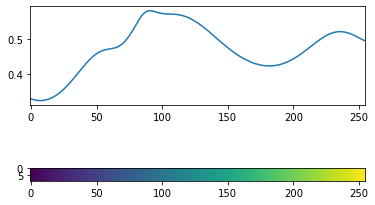

In [11]:
plot_cm_cdiffs(cm.viridis)

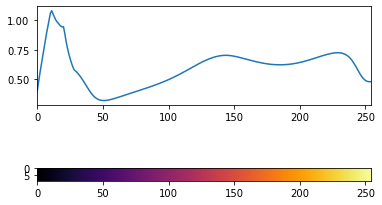

In [12]:
plot_cm_cdiffs(cm.inferno)

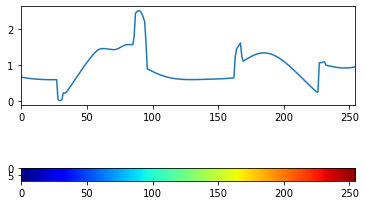

In [13]:
plot_cm_cdiffs(cm.jet)

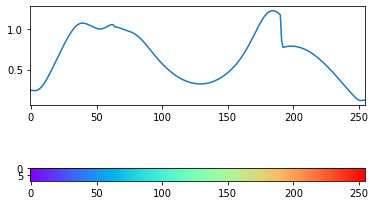

In [14]:
plot_cm_cdiffs(cm.rainbow)

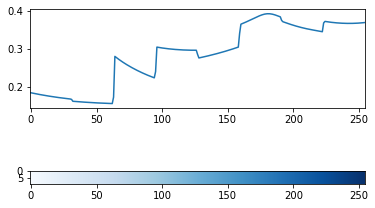

In [15]:
plot_cm_cdiffs(cm.Blues)

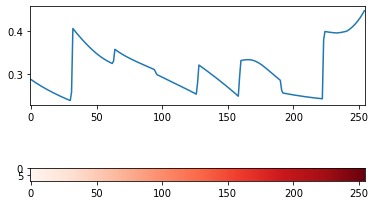

In [16]:
plot_cm_cdiffs(cm.Reds)

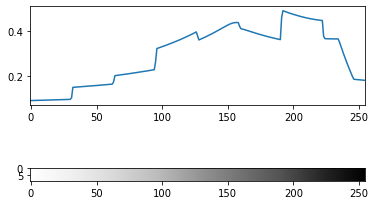

In [17]:
plot_cm_cdiffs(cm.Greys)

In [18]:
greys = cmap_to_cobj(cm.Greys, colorspace=LabColor)
cdiff(greys[-1], greys[0])/255


0.39215680353739507

In [19]:
np.mean(get_cmap_cdiffs(cm.Greys))

0.29471853478221743

In [20]:
greys[0].lab_l

99.99998453333127

In [21]:
def get_ldiff(colors):
    ls = [color.lab_l for color in colors]
    ldiff = [ls[i+1]-ls[i] for i in range(len(ls)-1)]
    return ldiff

In [22]:
np.sum(get_ldiff(greys))

-99.99998453333127

In [57]:
def optimise_cmap_l(colormap):
    color_list = cmap_to_cobj(colormap, colorspace=LabColor)
    ls = [color.lab_l for color in color_list]
    ldiffs = [ls[i+1]-ls[i] for i in range(len(ls)-1)]
    cdiffs = get_cmap_cdiffs(colormap)
    mean_cdiff = np.mean(cdiffs)
    l_fac = mean_cdiff/np.array(cdiffs)
    new_ldiffs = np.array(ldiffs)*l_fac
    new_ldiffs *= (ls[-1]-ls[0])/np.sum(new_ldiffs)
    new_ls = np.concatenate([[ls[0]],ls[0]+np.cumsum(new_ldiffs)])
    new_ls[-1] = ls[-1]
    for i,color in enumerate(color_list):
        color.lab_l = new_ls[i]
    rgb_colors = [convert_color(color, sRGBColor) 
                  for color in color_list]
    rgb = [[c.clamped_rgb_r, c.clamped_rgb_g, c.clamped_rgb_b]
       for c in rgb_colors]
    test_cmap = colors.ListedColormap(np.array(rgb))
    return test_cmap

def optimise_cmap_a(colormap):
    color_list = cmap_to_cobj(colormap, colorspace=LabColor)
    ls = [color.lab_a for color in color_list]
    ldiffs = [ls[i+1]-ls[i] for i in range(len(ls)-1)]
    cdiffs = get_cmap_cdiffs(colormap)
    mean_cdiff = np.mean(cdiffs)
    l_fac = mean_cdiff/np.array(cdiffs)
    new_ldiffs = np.array(ldiffs)*l_fac
    new_ldiffs *= (ls[-1]-ls[0])/np.sum(new_ldiffs)
    new_ls = np.concatenate([[ls[0]],ls[0]+np.cumsum(new_ldiffs)])
    new_ls[-1] = ls[-1]
    for i,color in enumerate(color_list):
        color.lab_a = new_ls[i]
    rgb_colors = [convert_color(color, sRGBColor) 
                  for color in color_list]
    rgb = [[c.clamped_rgb_r, c.clamped_rgb_g, c.clamped_rgb_b]
       for c in rgb_colors]
    test_cmap = colors.ListedColormap(np.array(rgb))
    return test_cmap

def optimise_cmap_b(colormap):
    color_list = cmap_to_cobj(colormap, colorspace=LabColor)
    ls = [color.lab_b for color in color_list]
    ldiffs = [ls[i+1]-ls[i] for i in range(len(ls)-1)]
    cdiffs = get_cmap_cdiffs(colormap)
    mean_cdiff = np.mean(cdiffs)
    l_fac = mean_cdiff/np.array(cdiffs)
    new_ldiffs = np.array(ldiffs)*l_fac
    new_ldiffs *= (ls[-1]-ls[0])/np.sum(new_ldiffs)
    new_ls = np.concatenate([[ls[0]],ls[0]+np.cumsum(new_ldiffs)])
    new_ls[-1] = ls[-1]
    for i,color in enumerate(color_list):
        color.lab_b = new_ls[i]
    rgb_colors = [convert_color(color, sRGBColor) 
                  for color in color_list]
    rgb = [[c.clamped_rgb_r, c.clamped_rgb_g, c.clamped_rgb_b]
       for c in rgb_colors]
    test_cmap = colors.ListedColormap(np.array(rgb))
    return test_cmap

def optimise_cmap_step(colormap):
    opt_l = optimise_cmap_l(colormap)
    opt_a = optimise_cmap_a(opt_l)
    opt_b = optimise_cmap_b(opt_a)
    return opt_b

def optimise_cmap(colormap, n_steps=5):
    cmap = optimise_cmap_step(colormap)
    for i in range(n_steps-1):
        cmap = optimise_cmap_step(cmap)
    return cmap


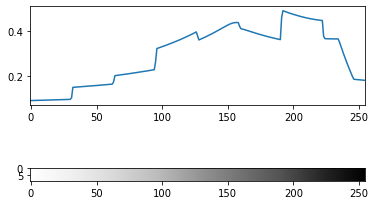

In [58]:
plot_cm_cdiffs(cm.Greys)

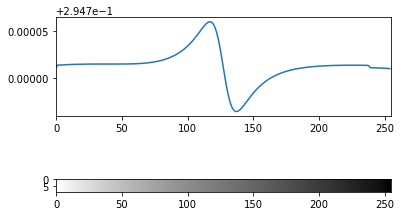

In [59]:
plot_cm_cdiffs(optimise_cmap(cm.Greys))

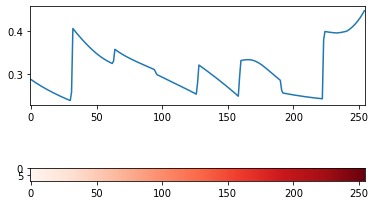

In [60]:
plot_cm_cdiffs(cm.Reds)

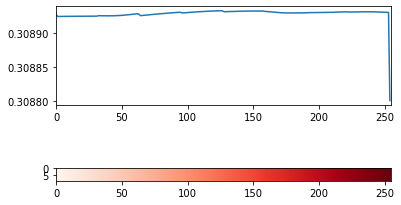

In [61]:
plot_cm_cdiffs(optimise_cmap(cm.Reds, n_steps=10))

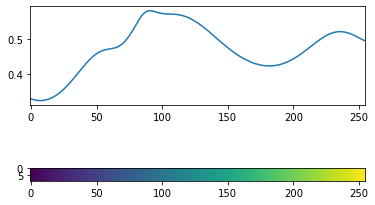

In [62]:
plot_cm_cdiffs(cm.viridis)

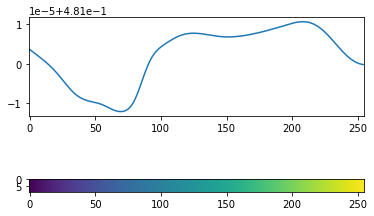

In [63]:
plot_cm_cdiffs(optimise_cmap(cm.viridis, n_steps=20))

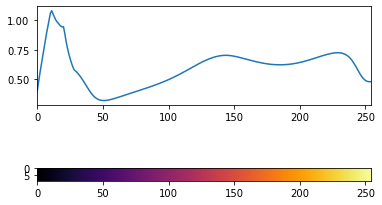

In [64]:
plot_cm_cdiffs(cm.inferno)

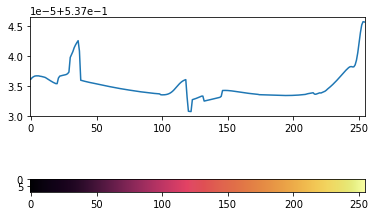

In [65]:
plot_cm_cdiffs(optimise_cmap(cm.inferno, n_steps=20))

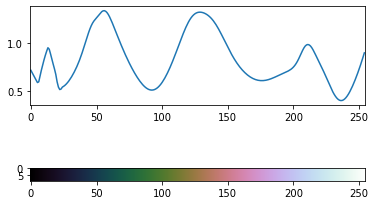

In [45]:
plot_cm_cdiffs(cm.cubehelix)

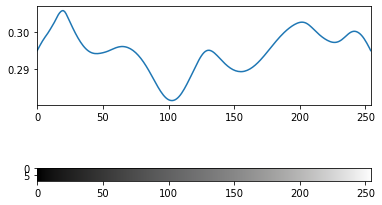

In [46]:
plot_cm_cdiffs(optimise_cmap(cm.cubehelix, n_steps=2))

In [139]:
greys = cmap_to_cobj(cm.Greys, colorspace=LCHabColor)

In [141]:
greys[0].lch_l

99.99998453333127